# Assignment 2 EE-610

The dataset for the assignment has been taken from the site
https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
from scipy import signal
from sklearn.metrics import mean_squared_error

## Step 1
Extracting Patches from the degraded images and central pixel from the clean images

In [2]:
#This function extract patches of size = patch_size and numPatches per image
def extract_patches(degraded_image,img,numPatches,patch_size):
    #Array to store patches of that image
    img_data_patch = []
    #Array to store Central pixel of the patch
    central_pixel_data = []
    
    #Generating Random patch
    for i in range(numPatches):
        x = random.randint(0, img.shape[0]-W) # Random x location so that the patch remains within image boundaries
        y = random.randint(0, img.shape[1]-W) # Random y location so that the patch remains within image boundaries
        patch = degraded_image[x:x+W,y:y+W,:] # Patch
        central_pixel = img[x + W//2, y + W//2, :] # Central Pixel
        
        img_data_patch.append(patch)
        central_pixel_data.append(central_pixel)
    
    return img_data_patch,central_pixel_data

In [3]:
#Image Blur - Applies blur to clean image(Mean Blur)
def image_blur(img,kernel_size = 5):
    kernel = np.zeros((kernel_size,kernel_size)) + 1.0/(kernel_size*kernel_size)
    blured_image = np.zeros((img.shape))
    for i in range(img.shape[2]):
        blured_image[:,:,i] = signal.convolve2d(img[:,:,i], kernel, boundary='symm', mode = 'same')
    return imgextent(blured_image)

#Add Gaussian Noise to image with given sigma
def gaussian_noise(img,sigma = 0.01):
    gauss_noise = np.random.normal(0, 0.01, img.shape)
    new_image = img + gauss_noise
    new_image = imgextent(new_image)
    return new_image
    
#Add saltandpepper noise to with given probability
def saltandpepper_noise(img,prob = 0.01):
    #Salt Noise
    salt_noise = np.random.choice([0,1],img.shape,p = [1-prob,prob])
    new_image = np.maximum(img,salt_noise)
       
    #Pepper Noise
    pepper_noise = np.random.choice([0,1],img.shape,p = [prob,1-prob])
    new_image = np.minimum(new_image,pepper_noise)
    return imgextent(new_image)
    
#Make sure the image pixel stays between 0 and 1    
def imgextent(image):
    image = np.maximum(image,0)
    image = np.minimum(image,1)
    return image
    

In [4]:
#Generates a dataset of patches and central pixel
def generate_data(folder_path,W,numPatches):
    #Data List
    datas = []
    
    #Label for data
    labels =[]
    
    for image_path in folder_path:
        img = image.imread(image_path)/255.0
        
        #Degrading the Image
        degraded_image = image_blur(img)
        degraded_image = gaussian_noise(degraded_image,0.05)
        degraded_image = saltandpepper_noise(degraded_image,0.05)
        
        #Extracting the patches
        data,label = extract_patches(degraded_image,img,numPatches,W)
        datas += data
        labels += label
        
    #Converting to Numpy Arrays    
    datas_np = np.array(datas)
    labels_np = np.array(labels)
    
    return datas_np,labels_np

In [5]:
def rmse_calculator(prd_image,clean_image,w):
    return mean_squared_error(clean_image[w//2:w//2+prd_image.shape[0],w//2:w//2+prd_image.shape[1]], prd_image, squared=False)

### Extracting data for training as well as validation

In [6]:
#Training Images Path
train_path = r"C:\Users\vipin\Desktop\Semester 5\EE 610\Assignment 2\BSDS300\images\train"
train_images_path = []

#Validation/Testing Images Path
test_path = r"C:\Users\vipin\Desktop\Semester 5\EE 610\Assignment 2\BSDS300\images\test"
test_images_path = []

#Making a list of address of each Image for training
for i in os.scandir(train_path):
    train_images_path.append(i.path)
    
#Making a list of address of each Image for training for testing    
for i in os.scandir(test_path):
    test_images_path.append(i.path)

I chose maximum patch size = 25 and number of patches per images = 3000. So I have training data set of 200*300 = 60000 patches.

In [7]:
numPatches = 300
W = 25
train_datas_un,train_labels_un = generate_data(train_images_path,W,numPatches)

shuffler = np.random.permutation(len(train_labels_un))
train_datas = train_datas_un[shuffler]
train_labels = train_labels_un[shuffler]

val_datas,val_labels = generate_data(test_images_path,W,numPatches)

The dataset is ready now
## Step 2
Generating test samples

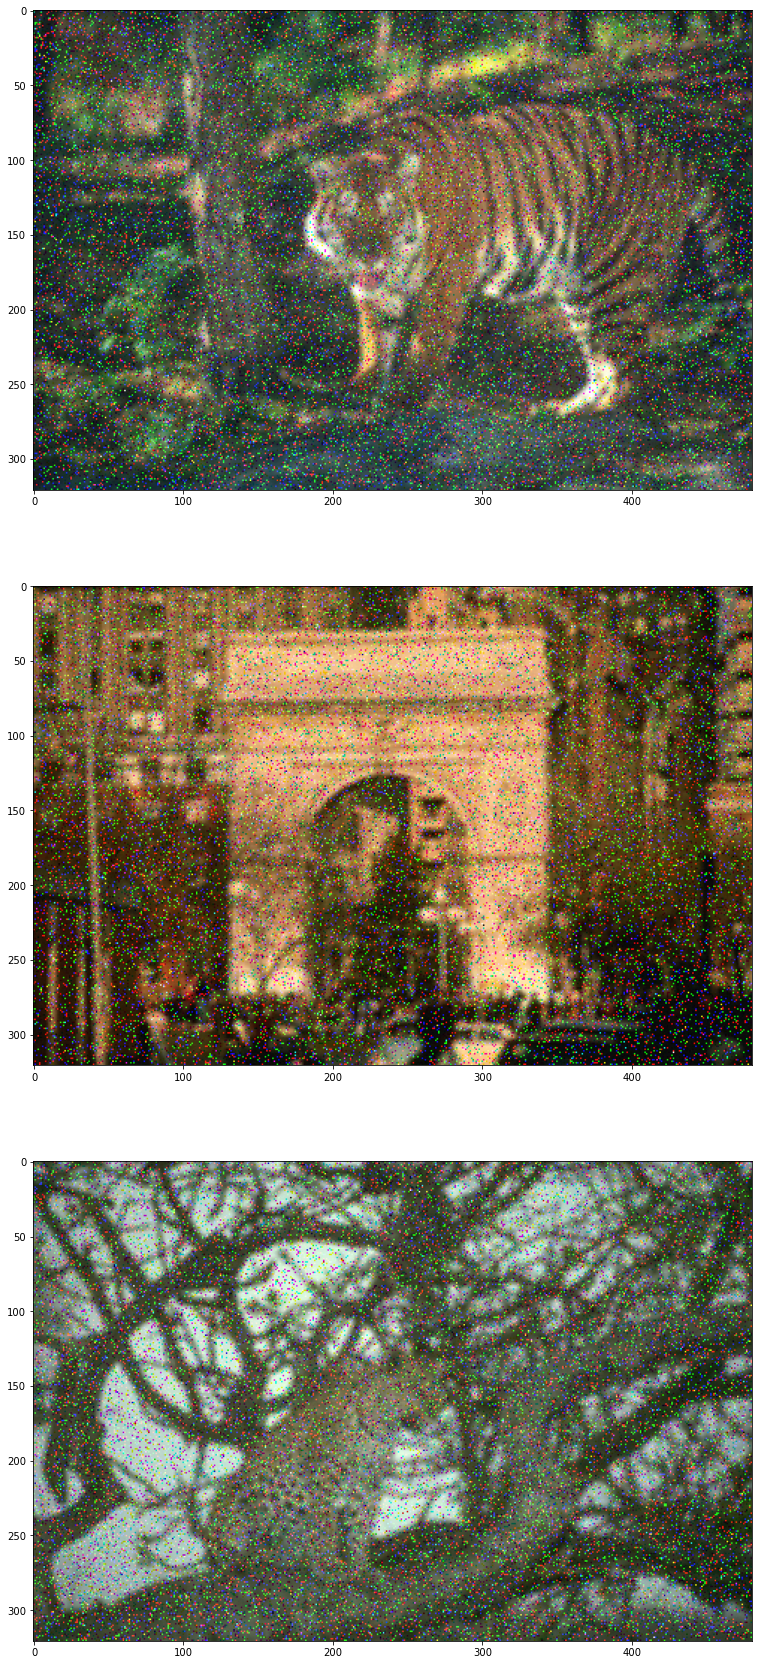

In [8]:
test_images = []
org_img = []
path =  r"C:\Users\vipin\Desktop\Semester 5\EE 610\Assignment 2\BSDS300\images\test"
for i in range(3):
    img = image.imread(test_images_path[np.random.randint(0,len(test_images_path))])
    org_img.append(img)
    img = img / 255.0
    deg_img = image_blur(img, 5)
    deg_img = gaussian_noise(deg_img, 0.05)
    deg_img = saltandpepper_noise(deg_img, 0.05)
    test_images.append(deg_img)
    
fig, ax = plt.subplots(nrows= len(test_images), ncols = 1, figsize = (30, 30))
for i in range(len(test_images)):
    ax[i].imshow(test_images[i])

plt.show()

The above picture are the test images for which I will see the prediction of my model

Now we need to train a model for different window sizes.
### MLP Regressor
As my first attemp for ML model I used MLP regressor from sklearn module.
I trained individual modey for each of the color channel. My initial guess is that with small window size(as the mean blur kernel size) would be sufficent for producing a clean image, with increasing window size performance should increase.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

In [10]:
# This Function helps to crop out the required patch size from the Image
def crop_data_generation(w,data_set):
    new_data_set = []
    for data in data_set:
        x,y,z = data.shape
        new_data = data[(x - w)//2 : (x + w)//2, (y - w)//2 : (y + w)//2, :]
        new_data_set.append(new_data)
    return new_data_set

### Training my Model for Different window Sizes.

In [11]:
# Performace keep track of validation for different patch sizes
performance = []
window_size = [5,7,9,11,13,15]

for w in window_size:
    #pref keep track of validation for different colour channel
    perf = []
    
    #Obtaining correct patch sizes
    train_datas_crop = crop_data_generation(w,train_datas)
    val_datas_crop = crop_data_generation(w,val_datas)
    
    #Expanding the image into 1-D Vector
    for i, z in enumerate(train_datas_crop):
        train_datas_crop[i] = z.reshape((-1,3))

    for i, z in enumerate(val_datas_crop):
        val_datas_crop[i] = z.reshape((-1,3))
        
    train_datas_crop = np.array(train_datas_crop)
    val_datas_crop = np.array(val_datas_crop)
    
    #Normalizing the data
    scaler_r = preprocessing.StandardScaler()
    scaler_g = preprocessing.StandardScaler()
    scaler_b = preprocessing.StandardScaler()
    
    scaler_r.fit(train_datas_crop[:,:,0])
    scaler_g.fit(train_datas_crop[:,:,1])
    scaler_b.fit(train_datas_crop[:,:,2])
    
    train_datas_r = scaler_r.transform(train_datas_crop[:,:,0])
    val_datas_r = scaler_r.transform(val_datas_crop[:,:,0])
    train_datas_g = scaler_g.transform(train_datas_crop[:,:,1])
    val_datas_g = scaler_g.transform(val_datas_crop[:,:,1])
    train_datas_b = scaler_b.transform(train_datas_crop[:,:,2])
    val_datas_b = scaler_b.transform(val_datas_crop[:,:,2])
    
    #Training the Model
    print("___________________________________________")
    print("Window_Size: ",w)
    print("___________________________________________")
    print("Red")
    print("___________________________________________")
    regr_r = MLPRegressor(hidden_layer_sizes = (100,50,25), learning_rate = 'adaptive', random_state = 7,verbose = True, early_stopping = True, tol = 1e-6)
    regr_r.fit(train_datas_r, train_labels[:,0])
    perf.append([w , regr_r.score(val_datas_r, val_labels[:,0])])
    print("___________________________________________")
    print("Green")
    print("___________________________________________")    
    regr_g = MLPRegressor(hidden_layer_sizes = (100,50,25), learning_rate = 'adaptive', random_state = 7,verbose = True, early_stopping = True, tol = 1e-6)
    regr_g.fit(train_datas_g, train_labels[:,1])
    perf.append([w , regr_g.score(val_datas_g, val_labels[:,1])])
    print("___________________________________________")
    print("Blue")
    print("___________________________________________")
    regr_b = MLPRegressor(hidden_layer_sizes = (100,50,25), learning_rate = 'adaptive', random_state = 7,verbose = True, early_stopping = True, tol = 1e-6)
    regr_b.fit(train_datas_b, train_labels[:,2])
    perf.append([w , regr_b.score(val_datas_b, val_labels[:,2])])
    performance.append(perf)


___________________________________________
Window_Size:  5
___________________________________________
Red
___________________________________________
Iteration 1, loss = 0.03193097
Validation score: 0.871503
Iteration 2, loss = 0.00361547
Validation score: 0.899815
Iteration 3, loss = 0.00312550
Validation score: 0.910510
Iteration 4, loss = 0.00295168
Validation score: 0.913178
Iteration 5, loss = 0.00284642
Validation score: 0.914953
Iteration 6, loss = 0.00280573
Validation score: 0.914077
Iteration 7, loss = 0.00275087
Validation score: 0.917100
Iteration 8, loss = 0.00271147
Validation score: 0.919462
Iteration 9, loss = 0.00267484
Validation score: 0.919439
Iteration 10, loss = 0.00263662
Validation score: 0.920389
Iteration 11, loss = 0.00259959
Validation score: 0.919377
Iteration 12, loss = 0.00258805
Validation score: 0.922153
Iteration 13, loss = 0.00252912
Validation score: 0.922428
Iteration 14, loss = 0.00249601
Validation score: 0.924312
Iteration 15, loss = 0.00244398

Iteration 4, loss = 0.00317056
Validation score: 0.904811
Iteration 5, loss = 0.00306128
Validation score: 0.907445
Iteration 6, loss = 0.00294802
Validation score: 0.909332
Iteration 7, loss = 0.00293287
Validation score: 0.908520
Iteration 8, loss = 0.00286656
Validation score: 0.908941
Iteration 9, loss = 0.00282081
Validation score: 0.909733
Iteration 10, loss = 0.00279262
Validation score: 0.911218
Iteration 11, loss = 0.00277065
Validation score: 0.912665
Iteration 12, loss = 0.00274840
Validation score: 0.910749
Iteration 13, loss = 0.00271623
Validation score: 0.913598
Iteration 14, loss = 0.00267671
Validation score: 0.914406
Iteration 15, loss = 0.00266937
Validation score: 0.912265
Iteration 16, loss = 0.00263850
Validation score: 0.912215
Iteration 17, loss = 0.00259299
Validation score: 0.913880
Iteration 18, loss = 0.00257349
Validation score: 0.915176
Iteration 19, loss = 0.00254046
Validation score: 0.914461
Iteration 20, loss = 0.00251864
Validation score: 0.902285
Ite

Iteration 21, loss = 0.00221361
Validation score: 0.919789
Iteration 22, loss = 0.00217143
Validation score: 0.918796
Iteration 23, loss = 0.00215497
Validation score: 0.918406
Iteration 24, loss = 0.00210334
Validation score: 0.920987
Iteration 25, loss = 0.00209483
Validation score: 0.921010
Iteration 26, loss = 0.00206176
Validation score: 0.918896
Iteration 27, loss = 0.00203265
Validation score: 0.920924
Iteration 28, loss = 0.00200625
Validation score: 0.921882
Iteration 29, loss = 0.00199814
Validation score: 0.921468
Iteration 30, loss = 0.00195942
Validation score: 0.921188
Iteration 31, loss = 0.00195226
Validation score: 0.916504
Iteration 32, loss = 0.00191547
Validation score: 0.920950
Iteration 33, loss = 0.00188100
Validation score: 0.921300
Iteration 34, loss = 0.00185935
Validation score: 0.922294
Iteration 35, loss = 0.00183273
Validation score: 0.922180
Iteration 36, loss = 0.00181291
Validation score: 0.918941
Iteration 37, loss = 0.00178404
Validation score: 0.9193

Iteration 1, loss = 0.01395651
Validation score: 0.843569
Iteration 2, loss = 0.00417961
Validation score: 0.881774
Iteration 3, loss = 0.00349403
Validation score: 0.892297
Iteration 4, loss = 0.00320831
Validation score: 0.898189
Iteration 5, loss = 0.00304564
Validation score: 0.900976
Iteration 6, loss = 0.00294287
Validation score: 0.901433
Iteration 7, loss = 0.00286929
Validation score: 0.904658
Iteration 8, loss = 0.00279457
Validation score: 0.905386
Iteration 9, loss = 0.00272160
Validation score: 0.906598
Iteration 10, loss = 0.00266109
Validation score: 0.906319
Iteration 11, loss = 0.00262741
Validation score: 0.904112
Iteration 12, loss = 0.00257564
Validation score: 0.905485
Iteration 13, loss = 0.00254963
Validation score: 0.906091
Iteration 14, loss = 0.00246861
Validation score: 0.905898
Iteration 15, loss = 0.00243526
Validation score: 0.905878
Iteration 16, loss = 0.00239924
Validation score: 0.906322
Iteration 17, loss = 0.00235704
Validation score: 0.905647
Iterat

Iteration 6, loss = 0.00265895
Validation score: 0.901881
Iteration 7, loss = 0.00257286
Validation score: 0.896498
Iteration 8, loss = 0.00250356
Validation score: 0.905384
Iteration 9, loss = 0.00241701
Validation score: 0.905473
Iteration 10, loss = 0.00235058
Validation score: 0.904659
Iteration 11, loss = 0.00229730
Validation score: 0.905502
Iteration 12, loss = 0.00223169
Validation score: 0.903724
Iteration 13, loss = 0.00217756
Validation score: 0.903331
Iteration 14, loss = 0.00212914
Validation score: 0.898096
Iteration 15, loss = 0.00208852
Validation score: 0.901212
Iteration 16, loss = 0.00202964
Validation score: 0.902290
Iteration 17, loss = 0.00196641
Validation score: 0.903230
Iteration 18, loss = 0.00191402
Validation score: 0.901986
Iteration 19, loss = 0.00187709
Validation score: 0.901221
Iteration 20, loss = 0.00184476
Validation score: 0.901391
Iteration 21, loss = 0.00179704
Validation score: 0.898034
Iteration 22, loss = 0.00176606
Validation score: 0.896835
V

Now our model are trained and we need to check for validation for different window size
### Plotting Validation for different patch size

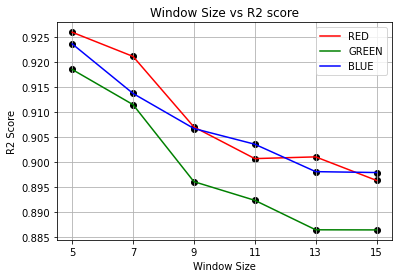

In [12]:
performance = np.array(performance)

#Plotting for RED Channel
plt.plot(performance[:,0,0], performance[:,0, 1],c = 'r')
plt.scatter(performance[:,0,0], performance[:,0, 1], c = 'k')

#Plotting for Green Channel
plt.plot(performance[:,1,0], performance[:,1, 1],c = 'g')
plt.scatter(performance[:,1,0], performance[:,1, 1], c = 'k')

#Plotting for BLUE Channel
plt.plot(performance[:,2,0], performance[:,2, 1],c = 'b')
plt.scatter(performance[:,2,0], performance[:,2, 1], c = 'k')

plt.title("Window Size vs R2 score")
plt.ylabel('R2 Score')
plt.xlabel('Window Size')
plt.xticks(range(5, 17, 2))
plt.legend(['RED','GREEN','BLUE'])
plt.grid()
plt.show()


AS we can see we get maximum R2 score for window size = 5, so we choose wopt = 5
### Retraining the Model for window size  = 5

In [13]:
wopt = 5
train_datas_crop = crop_data_generation(wopt,train_datas)
val_datas_crop = crop_data_generation(wopt,val_datas)
    
for i, z in enumerate(train_datas_crop):
    train_datas_crop[i] = z.reshape((-1,3))

for i, z in enumerate(val_datas_crop):
    val_datas_crop[i] = z.reshape((-1,3))
train_datas_crop = np.array(train_datas_crop)
val_datas_crop = np.array(val_datas_crop)    
        
scaler_r = preprocessing.StandardScaler()
scaler_g = preprocessing.StandardScaler()
scaler_b = preprocessing.StandardScaler()
    
scaler_r.fit(train_datas_crop[:,:,0])
scaler_g.fit(train_datas_crop[:,:,1])
scaler_b.fit(train_datas_crop[:,:,2])
    
train_datas_r = scaler_r.transform(train_datas_crop[:,:,0])
val_datas_r = scaler_r.transform(val_datas_crop[:,:,0])
train_datas_g = scaler_g.transform(train_datas_crop[:,:,1])
val_datas_g = scaler_g.transform(val_datas_crop[:,:,1])
train_datas_b = scaler_b.transform(train_datas_crop[:,:,2])
val_datas_b = scaler_b.transform(val_datas_crop[:,:,2])
    

print("Red")
print("___________________________________________")
regr_r = MLPRegressor(hidden_layer_sizes = (100,50,25), learning_rate = 'adaptive', random_state = 7,verbose = True, early_stopping = True, tol = 1e-6)
regr_r.fit(train_datas_r, train_labels[:,0])
print("___________________________________________")
print("Green")
print("___________________________________________")    
regr_g = MLPRegressor(hidden_layer_sizes = (100,50,25), learning_rate = 'adaptive', random_state = 7,verbose = True, early_stopping = True, tol = 1e-6)
regr_g.fit(train_datas_g, train_labels[:,1])
print("___________________________________________")
print("Blue")
print("___________________________________________")
regr_b = MLPRegressor(hidden_layer_sizes = (100,50,25), learning_rate = 'adaptive', random_state = 7,verbose = True, early_stopping = True, tol = 1e-6)
regr_b.fit(train_datas_b, train_labels[:,2])

Red
___________________________________________
Iteration 1, loss = 0.03193097
Validation score: 0.871503
Iteration 2, loss = 0.00361547
Validation score: 0.899815
Iteration 3, loss = 0.00312550
Validation score: 0.910510
Iteration 4, loss = 0.00295168
Validation score: 0.913178
Iteration 5, loss = 0.00284642
Validation score: 0.914953
Iteration 6, loss = 0.00280573
Validation score: 0.914077
Iteration 7, loss = 0.00275087
Validation score: 0.917100
Iteration 8, loss = 0.00271147
Validation score: 0.919462
Iteration 9, loss = 0.00267484
Validation score: 0.919439
Iteration 10, loss = 0.00263662
Validation score: 0.920389
Iteration 11, loss = 0.00259959
Validation score: 0.919377
Iteration 12, loss = 0.00258805
Validation score: 0.922153
Iteration 13, loss = 0.00252912
Validation score: 0.922428
Iteration 14, loss = 0.00249601
Validation score: 0.924312
Iteration 15, loss = 0.00244398
Validation score: 0.923059
Iteration 16, loss = 0.00239660
Validation score: 0.928630
Iteration 17, los

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50, 25),
             learning_rate='adaptive', random_state=7, tol=1e-06, verbose=True)

### Defining my cleaing function
The function takes image as an input and the window size = wopt and outputs a clean image prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  1 RMSE:  86.02007451739412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  2 RMSE:  105.36515309881297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  3 RMSE:  113.64154578134429


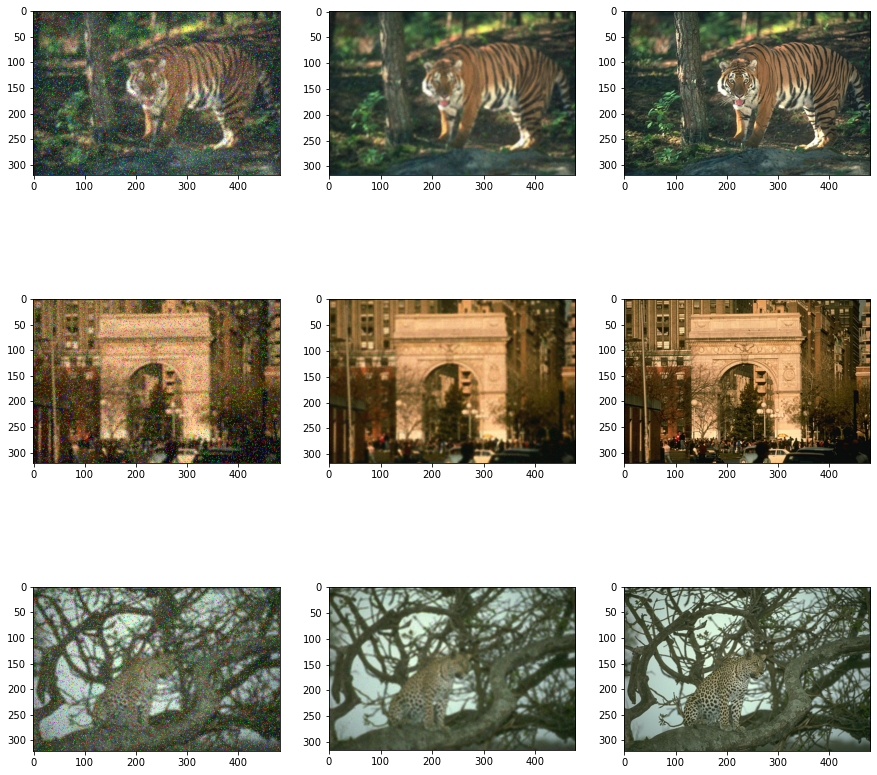

In [19]:
def cleaning_noisy_images(img,w):
    clean_img = np.zeros((img.shape[0] - 2*(w//2), img.shape[1] - 2*(w//2), img.shape[2]))
    for x in range(0, img.shape[0] - w + 1):
        row_patch = []
        for y in range(0, img.shape[1] - w + 1):
            row_patch.append(img[x : x + w, y : y + w, :])
        for i, patch in enumerate(row_patch):
            row_patch[i] = patch.reshape((-1,3))
        row_patch = np.array(row_patch)
                
        row_patch_r = scaler_r.transform(row_patch[:,:,0])
        row_patch_g = scaler_g.transform(row_patch[:,:,1])
        row_patch_b = scaler_b.transform(row_patch[:,:,2])
        prediction = np.array([regr_r.predict(row_patch_r),regr_g.predict(row_patch_g),regr_b.predict(row_patch_b)])
        for y in range(0, img.shape[1] - w + 1):
            clean_img[x, y, :] = prediction[:,y]
            
    return clean_img

#plot the cleaned images
fig, ax = plt.subplots(nrows= len(test_images), ncols = 3, figsize = (15, 15))
for i in range(len(test_images)):
    clean_img = cleaning_noisy_images((test_images[i]),wopt)
    ax[i][0].imshow(test_images[i])
    ax[i][1].imshow(clean_img)
    ax[i][2].imshow(org_img[i])
    
    a = rmse_calculator(clean_img [:,:,0],org_img[i][:,:,0],wopt)
    b = rmse_calculator(clean_img [:,:,1],org_img[i][:,:,1],wopt)
    c = rmse_calculator(clean_img [:,:,2],org_img[i][:,:,2],wopt)
    print("Image: ",i+1, "RMSE: ", (a+b+c)/3)
plt.show()

As we can see MLP regressor model that I trained does a fantastic job in cleaning images. Especially the salt and pepper noise.

## CNN Network
Now I design my own CNN network with 3 hidden layer and one fully connected layer. I use pytorch module for this task. I would like to give credit to the youtube video https://www.youtube.com/watch?v=c36lUUr864M.

In [20]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

image_transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [21]:
class mysimpleCNN(nn.Module):
    def __init__(self, w):
        # ancestor constructor call
        super(mysimpleCNN, self).__init__()
        self.w = w

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size= 3, padding=0)
        
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc = nn.Linear(64 * (self.w - 4) * (self.w - 4), 3) # !!!
    def forward(self, x):
        x = (F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation 
        x = (F.leaky_relu(self.bn2(self.conv2(x)))) # same as abobe
        x = (F.leaky_relu(self.bn3(self.conv3(x)))) 
        x = x.view(-1, 64 * (self.w - 4) * (self.w - 4)) # !!! # flatten
        x = F.relu(self.fc(x)) # pass through linear to give 3 outputs (R, G, B)
        return x

In [22]:
# makes the data as desired for CNN
class SimpleDataset(Dataset):
    def __init__(self, X, y, transform):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, index):
        return self.transform(self.X[index]) , torch.Tensor(self.y[index])

I use 20 epochs due to computation limitation of my computer.

In [23]:

# set hyperparameters
num_epochs = 20
batch_size = 200
learning_rate = 0.004

performance = []
#Decrease number of window size tried, as my computer was taking a lot of time
window_size = [5,7,9,11,13]

# training and evaluating model on different  window sizes
for w in window_size:

 
    train_data_crop = crop_data_generation(w,train_datas)
    val_data_crop = crop_data_generation(w,val_datas)
    
    train_data_final = SimpleDataset(train_data_crop, train_labels, image_transform) # initialize dataset objects for training set
    val_data_final = SimpleDataset(val_data_crop, val_labels, image_transform) # initialize dataset objects for validation set
 
    train_loader = DataLoader(dataset = train_data_final, batch_size=batch_size, shuffle=True) # wrap in dataloader
    val_loader = DataLoader(dataset = val_data_final, batch_size=batch_size//2, shuffle=True)
    print("___________________________________________")
    print("Window_Size: ",w)
    print("___________________________________________")

    model =  mysimpleCNN(w)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

    model.train()
    model.float()
    
    total_iter = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
        
            labels = torch.squeeze(labels) 

            
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Iter [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_iter, loss.item()))   

    model.eval()  
    with torch.no_grad():
        total_error = 0
        total_samples = 0
        for images, labels in val_loader:
            
            labels = torch.squeeze(labels)
            prediction = model(images.float())  
            total_samples += prediction.shape[0] 
            total_error += float(torch.sum((prediction - labels)**2)) 
            
        print(f'RMSE: {np.sqrt(total_error / total_samples)} ; W : {w}')
        performance.append([w, np.sqrt(total_error / total_samples)])

___________________________________________
Window_Size:  5
___________________________________________
Epoch [1/20], Iter [100/300], Loss: 0.0064
Epoch [1/20], Iter [200/300], Loss: 0.0057
Epoch [1/20], Iter [300/300], Loss: 0.0059
Epoch [2/20], Iter [100/300], Loss: 0.0061
Epoch [2/20], Iter [200/300], Loss: 0.0061
Epoch [2/20], Iter [300/300], Loss: 0.0067
Epoch [3/20], Iter [100/300], Loss: 0.0084
Epoch [3/20], Iter [200/300], Loss: 0.0053
Epoch [3/20], Iter [300/300], Loss: 0.0063
Epoch [4/20], Iter [100/300], Loss: 0.0076
Epoch [4/20], Iter [200/300], Loss: 0.0060
Epoch [4/20], Iter [300/300], Loss: 0.0070
Epoch [5/20], Iter [100/300], Loss: 0.0063
Epoch [5/20], Iter [200/300], Loss: 0.0055
Epoch [5/20], Iter [300/300], Loss: 0.0063
Epoch [6/20], Iter [100/300], Loss: 0.0067
Epoch [6/20], Iter [200/300], Loss: 0.0053
Epoch [6/20], Iter [300/300], Loss: 0.0053
Epoch [7/20], Iter [100/300], Loss: 0.0057
Epoch [7/20], Iter [200/300], Loss: 0.0055
Epoch [7/20], Iter [300/300], Loss: 

RMSE: 0.1317239330444014 ; W : 9
___________________________________________
Window_Size:  11
___________________________________________
Epoch [1/20], Iter [100/300], Loss: 0.2274
Epoch [1/20], Iter [200/300], Loss: 0.2199
Epoch [1/20], Iter [300/300], Loss: 0.2191
Epoch [2/20], Iter [100/300], Loss: 0.2142
Epoch [2/20], Iter [200/300], Loss: 0.2015
Epoch [2/20], Iter [300/300], Loss: 0.1980
Epoch [3/20], Iter [100/300], Loss: 0.2314
Epoch [3/20], Iter [200/300], Loss: 0.2064
Epoch [3/20], Iter [300/300], Loss: 0.2127
Epoch [4/20], Iter [100/300], Loss: 0.2500
Epoch [4/20], Iter [200/300], Loss: 0.2211
Epoch [4/20], Iter [300/300], Loss: 0.2206
Epoch [5/20], Iter [100/300], Loss: 0.2202
Epoch [5/20], Iter [200/300], Loss: 0.2301
Epoch [5/20], Iter [300/300], Loss: 0.2469
Epoch [6/20], Iter [100/300], Loss: 0.2140
Epoch [6/20], Iter [200/300], Loss: 0.2324
Epoch [6/20], Iter [300/300], Loss: 0.2121
Epoch [7/20], Iter [100/300], Loss: 0.2104
Epoch [7/20], Iter [200/300], Loss: 0.2530
Ep

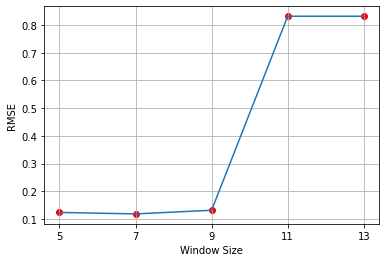

In [24]:
# plot of RMSE vs window size
performance = np.array(performance)
plt.plot(performance[:,0], performance[:, 1])
plt.scatter(performance[:,0], performance[:, 1], c = 'r')
plt.ylabel('RMSE')
plt.xlabel('Window Size')
plt.xticks(range(5, 14, 2))
plt.grid()
plt.show()

As we can see from the graph above the RMSE is minimum for w =7. So we train our model for window size = 7

### Retraining the CNN Network for w = 7

In [25]:
wopt = 7
train_data_crop = crop_data_generation(wopt,train_datas)
val_data_crop = crop_data_generation(wopt,val_datas)
    
train_data_final = SimpleDataset(train_data_crop, train_labels, image_transform)
val_data_final = SimpleDataset(val_data_crop, val_labels, image_transform) 
 
train_loader = DataLoader(dataset = train_data_final, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_data_final, batch_size=batch_size//2, shuffle=True)
model =  mysimpleCNN(wopt)

criterion = nn.MSELoss()  # mean square error loss
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

model.train()
model.float()
    
total_iter = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        labels = torch.squeeze(labels)

            
        outputs = model(images.float())
        loss = criterion(outputs, labels)
            
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Iter [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, i+1, total_iter, loss.item())) 


Epoch [1/20], Iter [100/300], Loss: 0.0105
Epoch [1/20], Iter [200/300], Loss: 0.0082
Epoch [1/20], Iter [300/300], Loss: 0.0059
Epoch [2/20], Iter [100/300], Loss: 0.0095
Epoch [2/20], Iter [200/300], Loss: 0.0073
Epoch [2/20], Iter [300/300], Loss: 0.0076
Epoch [3/20], Iter [100/300], Loss: 0.0098
Epoch [3/20], Iter [200/300], Loss: 0.0078
Epoch [3/20], Iter [300/300], Loss: 0.0051
Epoch [4/20], Iter [100/300], Loss: 0.0061
Epoch [4/20], Iter [200/300], Loss: 0.0049
Epoch [4/20], Iter [300/300], Loss: 0.0061
Epoch [5/20], Iter [100/300], Loss: 0.0066
Epoch [5/20], Iter [200/300], Loss: 0.0104
Epoch [5/20], Iter [300/300], Loss: 0.0054
Epoch [6/20], Iter [100/300], Loss: 0.0084
Epoch [6/20], Iter [200/300], Loss: 0.0098
Epoch [6/20], Iter [300/300], Loss: 0.0057
Epoch [7/20], Iter [100/300], Loss: 0.0080
Epoch [7/20], Iter [200/300], Loss: 0.0056
Epoch [7/20], Iter [300/300], Loss: 0.0059
Epoch [8/20], Iter [100/300], Loss: 0.0067
Epoch [8/20], Iter [200/300], Loss: 0.0084
Epoch [8/20

Now we need to redifne out function for cleaning noise
### Defining Cleaning function for image

In [26]:
model.eval()
model.float()
def cleaning_noisy_images(img,w):
    with torch.no_grad():
        clean_img = np.zeros((img.shape[0] - 2*(w//2), img.shape[1] - 2*(w//2), img.shape[2]))
        for x in range(0, img.shape[0] - w + 1):
            for y in range(0, img.shape[1] - w + 1):
                pred = model( (torch.unsqueeze(image_transform(img[x: x + w, y: y + w, :]), 0)).float())
                pred = torch.squeeze(pred)
                clean_img[x, y, : ] = np.array(pred)
    return clean_img

Cleaning the test samples from before

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  1 RMSE:  86.24776309853111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  2 RMSE:  105.60107286802615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image:  3 RMSE:  113.84339087131598


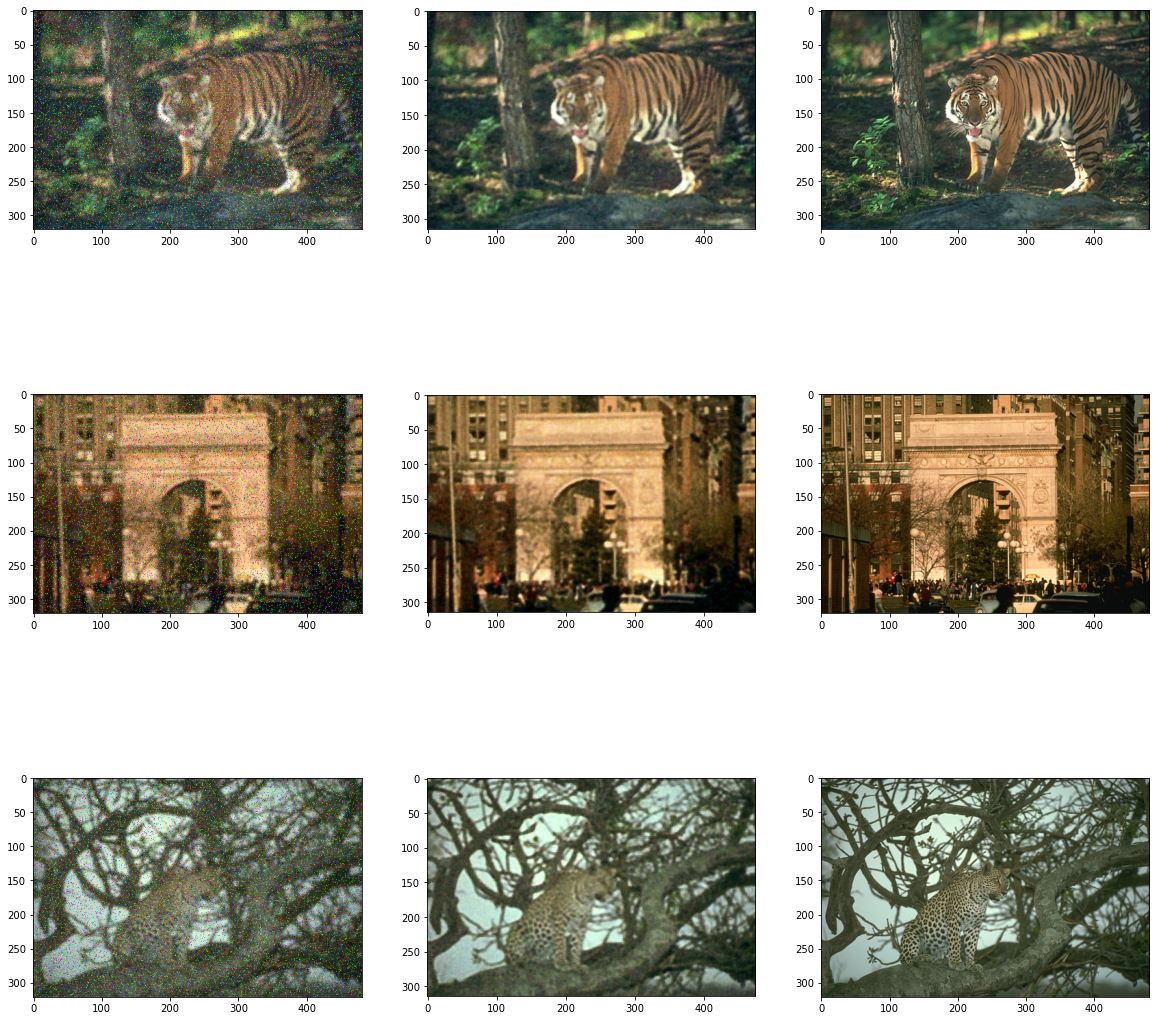

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (20, 20))

for i,img in enumerate(test_images):
    clean_img = cleaning_noisy_images(img,wopt)
    ax[i][0].imshow(img)
    ax[i][1].imshow(clean_img)
    ax[i][2].imshow(org_img[i])
    a = rmse_calculator(clean_img[:,:,0],org_img[i][:,:,0],wopt)
    b = rmse_calculator(clean_img[:,:,1],org_img[i][:,:,1],wopt)
    c = rmse_calculator(clean_img[:,:,2],org_img[i][:,:,2],wopt)
    print("Image: ",i+1, "RMSE: ", (a+b+c)/3)
plt.show()

Q) Initial guess of what trends you will observe about what will work better.<br>
Ans) 
As not according to my prediction CNN was less successfull in denoising the image. But quite to my shock with increase in size of window the RMSE increased. I think this may be due to data underfitting as my CNN was not too dense.


Q) Your observation, and any surprises in what worked better.<br>
Ans)
I observed that MLP regressor worked better, but to my suprise it worked best for small window size. I tried many possible CNN combination, and also tried different number and width of hidden layer for MLP Regressor. I think this was suprise due to underfitting as my CNN was not too dense.

## Reference

1) Deep Learning With PyTorch - Full Course(Youtube Video) - https://www.youtube.com/watch?v=c36lUUr864M <br>
2) Pytorch Documentation - https://pytorch.org/docs/stable/index.html <br>
3) SKlearn Documentation - https://pytorch.org/docs/stable/index.html <br>
4) https://towardsdatascience.com/image-noise-reduction-in-10-minutes-with-convolutional-autoencoders-d16219d2956a <br>

I would also like to thank my friend Sumit and Manan, who helped in the project.